In [1]:
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Enumerator
import Control.Monad
import Control.Arrow
import Data.Bifunctor (bimap)
import Numeric.Log
import qualified Data.Text as T

:e TupleSections


:l ../plotting.hs

# Bayesian Models

Monad-Bayes exports a `Bayesian` datatype to make using Bayesian models easier. The idea is that you specify your model as a prior, generative model and a likelihood (separate from the generative model because you can't always get the density of a sample from a distribution).

Once you've done that, a number of standard operations, like obtaining the posterior or the posterior predictive, are automated for you.

Here's a simple example:

In [71]:
model :: MonadSample m => Bayesian m Bool Double
model = Bayesian {
    prior = bernoulli 0.5,
    generative = \x -> normal (if x then 2 else (-2)) 1,
    likelihood  = \x y -> normalPdf (if x then 2 else (-2)) 1 y
    }

## Prior

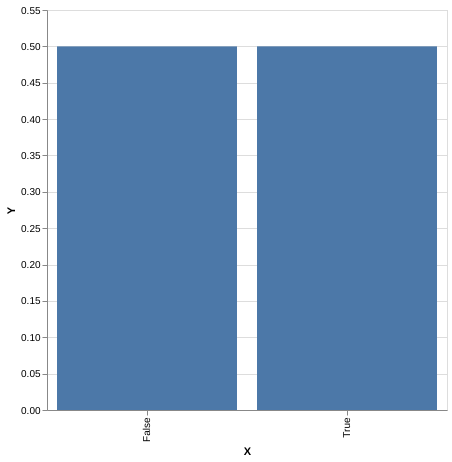

In [72]:
sampler $ 
    plot . fmap (first (T.pack . show)) . toEmpirical <$> 
    replicateM 100000 (prior model)

## Prior predictive

Prior predictive model is an application of the generative distribution to the prior distribution.

Similarly as in `Sampling.ipynb` example we need to introduce a constant weight by mapping samples to a pair (value, score) with `(,constWeight) <$> `.

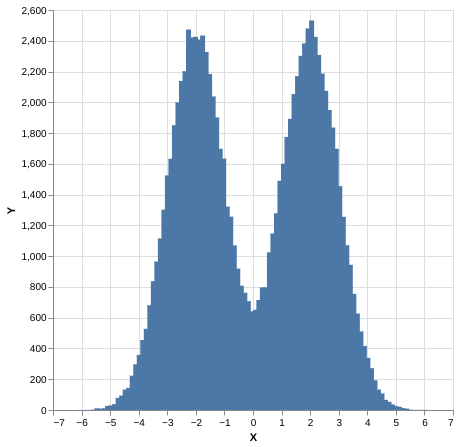

In [73]:
constWeight = 1 :: Log Double

sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 ((,constWeight) <$>  priorPredictive model)

## Posterior

Posterior distribution is computed using `likelihood` and observations $os = \{o_{1}, \dots o_{n} \}$.
Factors are computed for posterior for `model`: 
- $ \prod_{i=1}^{n} \text{likelihood}(\text{True}, o_{i}) $ for `True` value and
- $ \prod_{i=1}^{n} \text{likelihood}(\text{False}, o_{i}) $ for `False`.

Note that factors do not have to sum up to 1. Empirical distribution is obtained by normalizing factors to 1.


### Observations

In our example, we may experiment how observed data change the a priori model given the likelihood function. Observations should be in the domain of the likelihood function.

Taking symmetrical and evenly distributed points, we do not change the posterior distribution:

In [74]:
observations1 = [-3..3]
sampler $ toEmpiricalWeighted <$> replicateM 100000 (weighted $ posterior model observations1)

[(False,0.5022899999999909),(True,0.4977100000000092)]

On the other hand, if the observations are unevenly distributed adjustments to posterior are well visible:

In [75]:
observations2 = [-2.3, -2, 0, 0.3, 2, 2.3]
sampler $ toEmpiricalWeighted <$> replicateM 100000 (weighted $ posterior model observations2)

[(True,0.7686741811309296),(False,0.23132581886907125)]

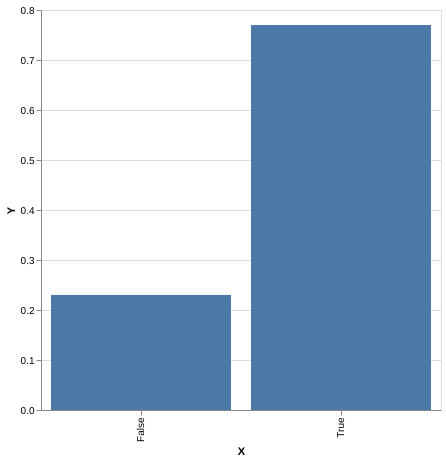

In [68]:
sampler $ 
    plot . fmap (bimap (T.pack . show) (ln . exp)) . toEmpiricalWeighted <$> 
    replicateM 1000 (weighted $ posterior model observations2)

### Excercise

Change the observations lists and see how the posterior is affected.
Change standard deviation of `likelihood` and see how posterior changes.


## Posterior predictive

Analoguosly to prior predictive is generated by `generative` applied to `posterior`.

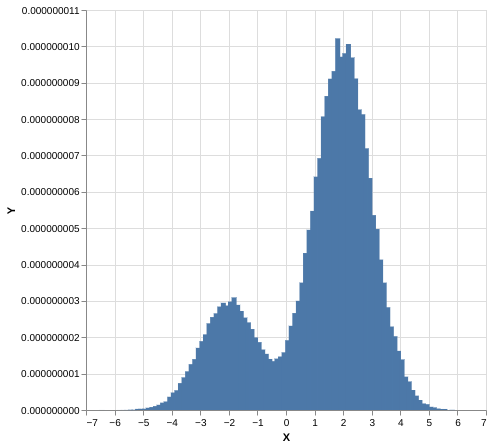

In [70]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 (weighted $ posteriorPredictive model observations2)

# Regression

And now an example with a regression:

In [14]:
:e BlockArguments 

range :: [Double]
range = [-10,-9.9..10] 


regression :: MonadSample m => Bayesian m (Double, Double, Double) [Double]
regression = Bayesian {
    prior = do 
            slope <- normal 0 2
            intercept <- normal 0 2
            noise <- gamma 4 4
            return (slope, intercept, noise),
    
    generative = \(slope, intercept, noise) -> do
            forM range \x -> normal (x*slope + intercept) (sqrt noise),
            
    likelihood = \(slope, intercept, noise) ys -> Prelude.sum [normalPdf (x*slope + intercept) (sqrt noise) y | (x,y) <- zip range ys] 
                
    }


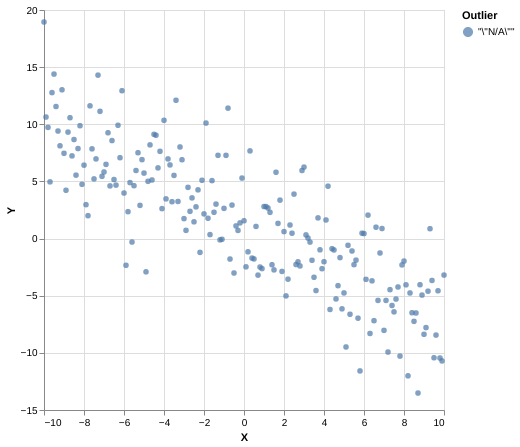

In [15]:
ys <- sampler $ priorPredictive regression

plot (fmap (second (T.pack . show)) (zip (zip range ys) (Prelude.repeat "N/A")))

In [16]:
import Control.Monad.Bayes.Inference.MCMC

ys <- sampleIOfixed $ mcmc MCMCConfig {numMCMCSteps = 5000, numBurnIn = 300, proposal = SingleSiteMH} 
    $ posteriorPredictive regression [take 200 $ repeat 1]


Line 1: Use head
Found:
ys !! 0
Why not:
head ys

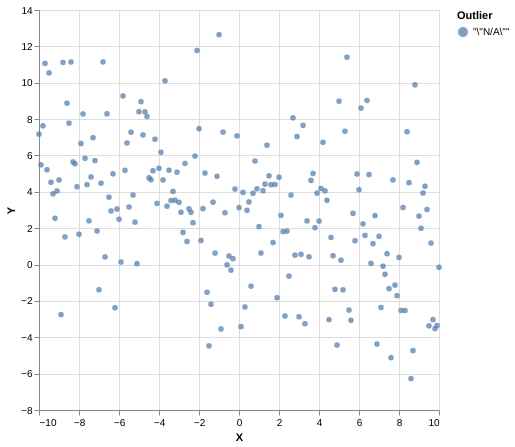

In [17]:
plot (fmap (second (T.pack . show)) (zip (zip range $ ys !! 0) (Prelude.repeat "N/A")))